# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 6 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 6 is due April 10, 2019

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [3]:
# RUN ON JUPYTER HUB
import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

In [110]:
import pyjags
import pandas as pd
import scipy as sp
from rpy2.robjects.packages import importr
r_utils = importr('utils')
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
r_coda = importr('coda')
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
from scipy.special import expit

Note that this has been tested with 
* pandas version 0.22.0
* rpy2 version 2.9.4

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.


<hr style="height:2pt">

### Problem 1: President Donald Trump's Tweets

In the first part of this assignment, you will be working with text from the @realDonaldTrump Twitter account. This consists of all tweets from the account from 5/4/2009 to 2/26/2019. The goal is to use Latent Dirichlet Allocation in order to model the topics tweeted about since President Trump's inauguration.

The dataset is from http://www.trumptwitterarchive.com/archive.

Start by reading the dataset into a pandas data frame.

In [5]:
#your code here
tweets_df = pd.read_csv('data/trump_tweets.csv')
display(tweets_df.dtypes)
tweets_df.head(10)

text          object
created_at    object
dtype: object

,text,created_at
0,Be sure to tune in and watch Donald Trump on L...,05-04-2009 18:54:25
1,Donald Trump will be appearing on The View tom...,05-05-2009 01:00:10
2,Donald Trump reads Top Ten Financial Tips on L...,05-08-2009 13:38:08
3,New Blog Post: Celebrity Apprentice Finale and...,05-08-2009 20:40:15
4,My persona will never be that of a wallflower ...,05-12-2009 14:07:28
5,"Miss USA Tara Conner will not be fired - ""I've...",05-12-2009 19:21:55
6,Listen to an interview with Donald Trump discu...,05-13-2009 17:38:28
7,Strive for wholeness and keep your sense of wo...,05-14-2009 16:30:40
8,"Enter the ""Think Like A Champion"" signed book ...",05-15-2009 14:13:13
9,When the achiever achieves it's not a plateau ...,05-16-2009 22:22:45


Now, extract only the rows since President Trump's inauguration on January 20, 2017 (you can use midnight on that date as the start time). You should use the datetime.strptime to convert dates to type `datetime`. Hint: first, you should remove any rows with missing timestamps.

In [6]:
#your code here
np.sum(tweets_df['created_at'].isnull())

4

In [7]:
tweets_df = tweets_df.dropna()
np.sum(tweets_df['created_at'].isnull())

0

In [8]:
now = datetime.now()
now.strftime('%m-%d-%y %H:%M:%S')

'04-07-19 18:20:07'

In [9]:
datetime.strptime(tweets_df['created_at'][0], "%m-%d-%Y %H:%M:%S")

datetime.datetime(2009, 5, 4, 18, 54, 25)

Preprocess the data by making it all lowercase. Remove a reasonable set of stopwords from the dataset and tokenize. Then, report the 50 most common words and their count. You may need to iterate this process, adding some stop words as you understand the structure of the data. Justify additional stop words you've added.


In [10]:
#your code here

Find the optimal number of topics using the `u_mass` coherence measure. Plot the results; what does this plot suggest about the number of topics in the text?

In [11]:
#your code here

Run LDA on the texts using the optimal value of $k$ found via your analysis above. Print out the top 10 words and associated betas for each of the $k$ topics. Comment on the results and their plausibility. What does each topic seem to represent?

In [12]:
#your code here

### Problem 2: Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset-2-train.csv` and `dataset-2-test.csv` containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order.

In [13]:
#your code here
train = pd.read_csv('data/dataset_2_train.csv')
train.describe()

,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,29.680455,0.307135,2.591520,-0.310626,0.389866
std,17.713976,0.461545,1.248457,8.995747,0.487972
min,1.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,46.000000,1.000000,4.000000,6.440000,1.000000
max,61.000000,1.000000,4.000000,19.440000,1.000000


In [15]:
train.dtypes

district               int64
urban                  int64
living.children        int64
age_mean             float64
contraceptive_use      int64
dtype: object

In [16]:
train['district'].unique()

array([35, 22, 29,  5, 34, 30, 10, 44, 58, 24, 51, 28, 46, 36, 14, 56, 19,
       18, 31, 43, 25,  8, 60, 40,  4,  6,  7, 61, 26, 21, 45, 13, 52,  1,
       48, 16, 57, 17, 42, 12, 39, 59, 37, 27, 32, 20, 15, 53,  9,  3, 11,
       55, 33, 38, 47,  2, 49, 41, 23, 50])

In [17]:
train['district'][train['district']==61] = 54
train['district'].unique()

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


array([35, 22, 29,  5, 34, 30, 10, 44, 58, 24, 51, 28, 46, 36, 14, 56, 19,
       18, 31, 43, 25,  8, 60, 40,  4,  6,  7, 54, 26, 21, 45, 13, 52,  1,
       48, 16, 57, 17, 42, 12, 39, 59, 37, 27, 32, 20, 15, 53,  9,  3, 11,
       55, 33, 38, 47,  2, 49, 41, 23, 50])

To verify the procedure, simulate binary response data assuming the following parameter values (and using the existing features and district information from the training data):

$\mu_{\beta_0} = 2$

$\sigma^2_{\beta_0} = 1$

$\beta_0 \sim N(\mu_{\beta_0},\sigma_{\beta_0}^2)$

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

In [121]:
#your code here

N = train.shape[0]
mu = 2
sigma_beta0 = 1
beta1 = 4
beta2 = -3
beta3 = -2

beta0 = []
z = []
p = []
y_sim = []

for i in range(train.shape[0]):
    beta0.append(np.random.normal(mu, sigma_beta0))
    z.append(beta0[i] + beta1*train["urban"][i] + beta2*train["living.children"][i] + beta3*train["age_mean"][i])
    p.append(expit(z[i]))

    y_sim.append(np.random.binomial(1, p[i]))

y_simulated = np.array(y_sim)

In [122]:
train['simulated_y'] = y_simulated

Fit the varying-intercept model specified above to your simulated data.

In [123]:
#your code here
varying_intercept_code = '''
model {
    mu0 ~ dnorm(0, 1/pow(10000,2))
    isigma2 ~ dgamma(0.1, 0.1)
    beta1 ~ dnorm(0, 1/pow(10000,2))
    beta2 ~ dnorm(0, 1/pow(10000,2))
    beta3 ~ dnorm(0, 1/pow(10000,2))
    
    for (j in J){
        beta0[j] ~ dnorm(mu0, isigma2)
        }
        
    for (i in 1:N){
        y[i] ~ dbern(p[i])
        logit(p[i]) <- beta0[district[i]] + beta1*urban[i] + beta2*living_children[i] + beta3*age_mean[i]
        }
        
}
'''

In [124]:
observed_vals = {'y': train["simulated_y"],
                 'urban': train["urban"],
                 'living_children': train["living.children"],
                 'age_mean': train["age_mean"],
                 'district': train["district"],
                 'J': train["district"].unique(),
                 'N': train.shape[0]}

num_chains = 4
train_model = pyjags.Model(code=varying_intercept_code, data=observed_vals, chains=4)
burnin = train_model.sample(500) 
samples = train_model.sample(2500)

adapting: iterations 1320 of 4000, elapsed 0:00:05, remaining 0:00:11
adapting: iterations 2552 of 4000, elapsed 0:00:11, remaining 0:00:06
adapting: iterations 4000 of 4000, elapsed 0:00:16, remaining 0:00:00
adapting: iterations 4000 of 4000, elapsed 0:00:16, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 2000 of 2000, elapsed 0:00:09, remaining 0:00:00
sampling: iterations 1164 of 10000, elapsed 0:00:05, remaining 0:00:40
sampling: iterations 3388 of 10000, elapsed 0:00:15, remaining 0:00:29
sampling: iterations 5664 of 10000, elapsed 0:00:25, remaining 0:00:19
sampling: iterations 6816 of 10000, elapsed 0:00:30, remaining 0:00:14
sampling: iterations 7960 of 10000, elapsed 0:00:35, remaining 0:00:09
sampling: iterations 9088 of 10000, elapsed 0:00:40, remaining 0:00:04
sampling: iterations 10000 of 10000, elapsed 0:00:44, remaining 0:00:00


Plot the trace plots of the MCMC sampler for the parameters $\mu_{\beta_0}, \sigma_{\beta_0}, \beta_1, \beta_2, \beta_3$. Does it look like the samplers converged?

In [125]:
def plot_trace(samples, varnames, entry=0):
    plt.plot()
    
    for var in varnames:
        sample_array = samples[var]
        plt.xlabel("Iteration")
        plt.ylabel("Value of {}".format(var))

        vec_len, num_samples, num_chains = sample_array.shape
        for cur_chain in range(num_chains):
            cur_label = "Chain {}".format(cur_chain)
            plt.plot(range(num_samples),sample_array[entry,:,cur_chain], label=cur_label)
        plt.legend()
        plt.show()

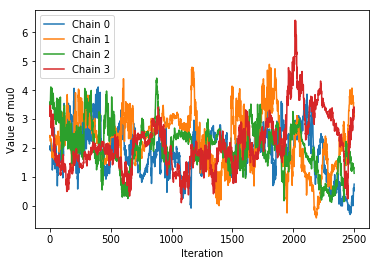

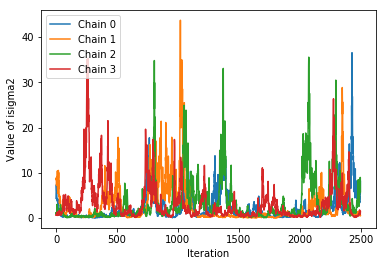

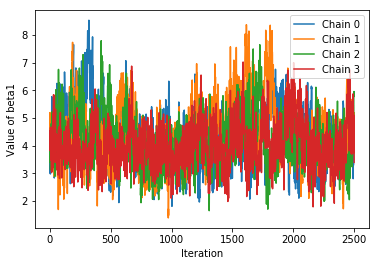

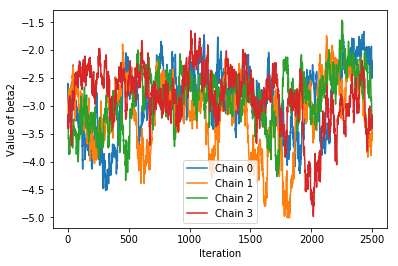

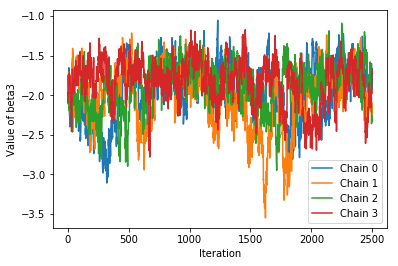

In [126]:
plot_trace(samples, varnames=['mu0', 'isigma2', 'beta1', 'beta2', 'beta3'])

your response here

Plot histograms of the posterior distributions for the parameters $\beta_{0,10}$, $\beta_{0,20}$,...,$\beta_{0,60}$. Are the actual parameters that you generated contained within these posterior distributions? 

In [12]:
#your code here

your response here

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [ ]:
#your code here

your response here

Check the convergence by examining the trace plots, as you did with the simulated data. What do you observe?

In [14]:
#your code here

your response here

Based on the posterior means, women belonging to which district are most likely to use contraceptives? Women belonging to which district are least likely to use contraceptives?

In [15]:
#your code here

your response here

What are the posterior means of $\mu_{\beta_0}$ and $\sigma^2_{\beta_0}$? Do these values offer any evidence in support of or against the varying-intercept model?

In [16]:
#your code here

your response here

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [17]:
#your code here

your response here

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [ ]:
#your code here

your response here